In [1]:
# Required Libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [117]:
# Load Data
image_folder = r"C:\Users\barto\Documents\Kody\MachineLearning\Project4\trainingset1"
excel_file = r"Labels.csv"

# Load the Excel file containing labels
df = pd.read_csv(excel_file)

# Prepare data and labels
image_data = []
labels = []

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return np.array(image)

for index, row in df.iterrows():
    image_id = row['ImageId']
    classification = row['ClassName']
    image_path = os.path.join(image_folder, image_id)
    
    if os.path.exists(image_path):
        try:
            image_array = preprocess_image(image_path)
            image_data.append(image_array)
            labels.append(classification)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

image_data = np.array(image_data).astype(np.float32)
image_data = image_data / 255.0
labels = np.array(labels)

In [118]:
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels)
y_train_one_hot = np.zeros((labels.size, len(label_encoder.classes_)))
y_train_one_hot[np.arange(labels_numeric.size), labels_numeric] = 1

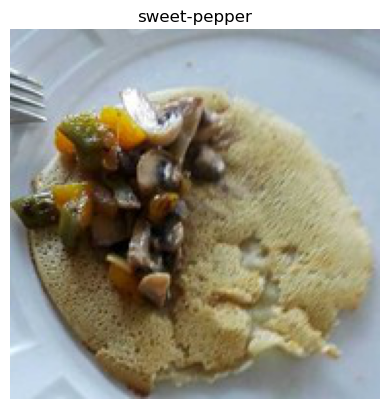

In [14]:
import matplotlib.pyplot as plt

number = 20
plt.imshow(image_data[number, :, :, :])
plt.title(f"{labels[number]}")
plt.axis('off')  # Turn off axis for a cleaner look
plt.show()

In [114]:
# -------------------------
# Helper Functions
# -------------------------
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(x.dtype)

def softmax(x):
    # Softmax per row (batch axis = 0)
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    # y_true and y_pred shape: (batch_size, num_classes)
    eps = 1e-9
    return -np.sum(y_true * np.log(y_pred + eps)) / y_true.shape[0]

def flatten(x):
    # Flatten all but the batch dimension
    return x.reshape(x.shape[0], -1)


class ThreeLayerCNN:
    def __init__(self, input_shape, num_classes):
        """
        input_shape = (height, width, channels)
        We'll do three conv layers in sequence: 
          8 filters -> ReLU -> MaxPool
          16 filters -> ReLU -> MaxPool
          32 filters -> ReLU -> MaxPool
        Then Flatten -> FC -> ReLU -> Output -> Softmax
        """
        self.input_shape = input_shape
        self.num_classes = num_classes

        # ------------------
        # Convolution layer filters
        #   conv1: 8 filters
        #   conv2: 16 filters
        #   conv3: 32 filters
        # Each uses a 3x3 kernel, stride=1, no padding
        # ------------------
        self.conv_filter1 = np.random.randn(3, 3, input_shape[2], 8)  * 0.1
        self.conv_filter2 = np.random.randn(3, 3, 8, 16)              * 0.1
        self.conv_filter3 = np.random.randn(3, 3, 16, 32)             * 0.1

        # We'll do stride=1, pad=0 for all convs
        self.conv_stride = 1
        self.conv_pad = 0

        # ------------------
        # Figure out the spatial size after each block:
        #   conv (3x3, stride=1, pad=0) reduces H/W by 2
        #   maxpool (2x2, stride=2) halves H/W
        # We'll do that 3 times.
        # ------------------
        def after_conv(size):
            return size - 2  # 3x3 kernel, stride=1 => out = in - 2
        def after_pool(size):
            return size // 2 # 2x2 kernel, stride=2 => out = in//2

        H0, W0, C0 = input_shape
        # 1st block
        H1, W1 = after_pool(after_conv(H0)), after_pool(after_conv(W0))
        # 2nd block
        H2, W2 = after_pool(after_conv(H1)), after_pool(after_conv(W1))
        # 3rd block
        H3, W3 = after_pool(after_conv(H2)), after_pool(after_conv(W2))

        # After the 3rd conv, we have 32 channels
        flattened_size = 32 * H3 * W3

        # ------------------
        # Fully connected + output
        # ------------------
        self.fc_weights = np.random.randn(flattened_size, 128) * 0.1
        self.fc_bias    = np.zeros((1, 128))

        self.output_weights = np.random.randn(128, num_classes) * 0.1
        self.output_bias    = np.zeros((1, num_classes))


        # ------------------
        # Pooling params
        # ------------------
        self.pool_size   = 2
        self.pool_stride = 2

        # ------------------
        # We'll store intermediates for forward/backward
        # ------------------
        self.conv_output1  = None
        self.relu_output1  = None
        self.pool_output1  = None
        self.pool_mask1    = None

        self.conv_output2  = None
        self.relu_output2  = None
        self.pool_output2  = None
        self.pool_mask2    = None

        self.conv_output3  = None
        self.relu_output3  = None
        self.pool_output3  = None
        self.pool_mask3    = None

        self.flattened     = None
        self.fc_output     = None

        # ------------------
        # Adam hyperparams & accumulators
        # ------------------
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps   = 1e-8

        # Time step for bias correction
        self.t = 0

        # First and second moment accumulators for each parameter
        # conv1
        self.m_conv_filter1 = np.zeros_like(self.conv_filter1)
        self.v_conv_filter1 = np.zeros_like(self.conv_filter1)
        # conv2
        self.m_conv_filter2 = np.zeros_like(self.conv_filter2)
        self.v_conv_filter2 = np.zeros_like(self.conv_filter2)
        # conv3
        self.m_conv_filter3 = np.zeros_like(self.conv_filter3)
        self.v_conv_filter3 = np.zeros_like(self.conv_filter3)

        # FC
        self.m_fc_weights = np.zeros_like(self.fc_weights)
        self.v_fc_weights = np.zeros_like(self.fc_weights)
        self.m_fc_bias    = np.zeros_like(self.fc_bias)
        self.v_fc_bias    = np.zeros_like(self.fc_bias)

        # Output
        self.m_output_weights = np.zeros_like(self.output_weights)
        self.v_output_weights = np.zeros_like(self.output_weights)
        self.m_output_bias    = np.zeros_like(self.output_bias)
        self.v_output_bias    = np.zeros_like(self.output_bias)

    # ----------------------------------------------------
    # Forward-building blocks
    # ----------------------------------------------------
    def convolve_forward(self, x, filters, stride=1, padding=0):
        """
        x shape: (batch_size, H, W, in_channels)
        filters shape: (fH, fW, in_channels, out_channels)
        returns: (batch_size, outH, outW, out_channels)
        """
        batch_size, inH, inW, inC = x.shape
        fH, fW, _, outC = filters.shape

        outH = (inH - fH + 2*padding) // stride + 1
        outW = (inW - fW + 2*padding) // stride + 1

        out = np.zeros((batch_size, outH, outW, outC))

        for b in range(batch_size):
            for oh in range(outH):
                for ow in range(outW):
                    h_start = oh * stride
                    w_start = ow * stride
                    region = x[b, h_start:h_start+fH, w_start:w_start+fW, :]
                    for c in range(outC):
                        out[b, oh, ow, c] = np.sum(region * filters[:, :, :, c])
        return out

    def max_pool_forward(self, x, pool_size=2, stride=2):
        """
        x shape: (batch_size, H, W, channels)
        returns:
          pooled: (batch_size, outH, outW, channels)
          mask:   index of max in each region
        """
        batch_size, inH, inW, inC = x.shape
        outH = (inH - pool_size) // stride + 1
        outW = (inW - pool_size) // stride + 1

        pooled = np.zeros((batch_size, outH, outW, inC))
        mask   = np.zeros((batch_size, outH, outW, inC), dtype=np.int32)

        for b in range(batch_size):
            for c in range(inC):
                for oh in range(outH):
                    for ow in range(outW):
                        h_start = oh * stride
                        w_start = ow * stride
                        region = x[b, h_start:h_start+pool_size, w_start:w_start+pool_size, c]
                        region_flat = region.flatten()
                        max_idx = np.argmax(region_flat)
                        pooled[b, oh, ow, c] = region_flat[max_idx]
                        mask[b, oh, ow, c]   = max_idx
        return pooled, mask

    # ----------------------------------------------------
    # Backward-building blocks
    # ----------------------------------------------------
    def convolve_backward(self, d_out, x, filters, stride=1, padding=0):
        """
        d_out: gradient wrt conv output: (batch_size, outH, outW, outC)
        x:     input to conv_forward
        filters: (fH, fW, inC, outC)
        
        returns:
          d_x, d_filters
        """
        batch_size, inH, inW, inC = x.shape
        fH, fW, _, outC = filters.shape

        d_x = np.zeros_like(x)
        d_filters = np.zeros_like(filters)

        outH, outW = d_out.shape[1], d_out.shape[2]

        for b in range(batch_size):
            for oh in range(outH):
                for ow in range(outW):
                    h_start = oh * stride
                    w_start = ow * stride
                    for c in range(outC):
                        grad_val = d_out[b, oh, ow, c]
                        region_x = x[b, h_start:h_start+fH, w_start:w_start+fW, :]
                        # w.r.t. filters
                        d_filters[:, :, :, c] += region_x * grad_val
                        # w.r.t. input
                        d_x[b, h_start:h_start+fH, w_start:w_start+fW, :] += filters[:, :, :, c] * grad_val
        return d_x, d_filters

    def max_pool_backward(self, d_out, x_shape, pool_mask, pool_size=2, stride=2):
        """
        d_out:   grad wrt pooled output
        x_shape: shape of the input to the forward pooling
        pool_mask: indexes of the max element in each region
        returns:
          d_x, shape x_shape
        """
        batch_size, inH, inW, inC = x_shape
        outH, outW = d_out.shape[1], d_out.shape[2]

        d_x = np.zeros(x_shape)

        for b in range(batch_size):
            for c in range(inC):
                for oh in range(outH):
                    for ow in range(outW):
                        grad_val = d_out[b, oh, ow, c]
                        max_i = pool_mask[b, oh, ow, c]
                        # unravel index
                        row_offset = max_i // pool_size
                        col_offset = max_i % pool_size
                        h_start = oh * stride
                        w_start = ow * stride
                        d_x[b, h_start + row_offset, w_start + col_offset, c] += grad_val
        return d_x

    # ----------------------------------------------------
    # Forward
    # ----------------------------------------------------
    def forward(self, x):
        # ---- Conv1 -> ReLU -> Pool1
        self.conv_output1 = self.convolve_forward(x, self.conv_filter1,
                                                  stride=self.conv_stride,
                                                  padding=self.conv_pad)
        self.relu_output1 = relu(self.conv_output1)
        self.pool_output1, self.pool_mask1 = self.max_pool_forward(self.relu_output1,
                                                                   pool_size=self.pool_size,
                                                                   stride=self.pool_stride)

        # ---- Conv2 -> ReLU -> Pool2
        self.conv_output2 = self.convolve_forward(self.pool_output1, self.conv_filter2,
                                                  stride=self.conv_stride,
                                                  padding=self.conv_pad)
        self.relu_output2 = relu(self.conv_output2)
        self.pool_output2, self.pool_mask2 = self.max_pool_forward(self.relu_output2,
                                                                   pool_size=self.pool_size,
                                                                   stride=self.pool_stride)

        # ---- Conv3 -> ReLU -> Pool3
        self.conv_output3 = self.convolve_forward(self.pool_output2, self.conv_filter3,
                                                  stride=self.conv_stride,
                                                  padding=self.conv_pad)
        self.relu_output3 = relu(self.conv_output3)
        self.pool_output3, self.pool_mask3 = self.max_pool_forward(self.relu_output3,
                                                                   pool_size=self.pool_size,
                                                                   stride=self.pool_stride)

        # ---- Flatten
        self.flattened = flatten(self.pool_output3)

        # ---- FC -> ReLU
        fc_in = self.flattened
        fc_linear = np.dot(fc_in, self.fc_weights) + self.fc_bias
        self.fc_output = relu(fc_linear)

        # ---- Output -> Softmax
        logits = np.dot(self.fc_output, self.output_weights) + self.output_bias
        # fc_output: (batch_size, 128)
        # output_weights: (128, num_classes)
        # => logits: (batch_size, num_classes)

        predictions = softmax(logits)
        return predictions

    # ----------------------------------------------------
    # Backward (Adam)
    # ----------------------------------------------------
    def backward(self, x, y_true, y_pred, learning_rate=1e-3):
        """
        Full backprop with Adam optimizer.
        """
        batch_size = x.shape[0]
        # Increase time step (for bias correction)
        self.t += 1

        # 1) Grad wrt logits (cross-entropy + softmax)
        d_logits = (y_pred - y_true) / batch_size

        # ---- grads for output layer
        d_output_weights = np.dot(self.fc_output.T, d_logits)           
        d_output_bias    = np.sum(d_logits, axis=0, keepdims=True)      

        # 2) Backprop to FC output
        d_fc_output = np.dot(d_logits, self.output_weights.T)  
        d_fc_output *= relu_derivative(self.fc_output)

        # ---- grads for FC weights & bias
        d_fc_weights = np.dot(self.flattened.T, d_fc_output)    
        d_fc_bias    = np.sum(d_fc_output, axis=0, keepdims=True)

        # 3) Backprop to flattened input
        d_flattened = np.dot(d_fc_output, self.fc_weights.T)   
        d_pool_output3 = d_flattened.reshape(self.pool_output3.shape)

        # ---- Unpool3
        d_relu_output3 = self.max_pool_backward(d_pool_output3,
                                                self.conv_output3.shape,
                                                self.pool_mask3,
                                                pool_size=self.pool_size,
                                                stride=self.pool_stride)
        d_conv_output3 = d_relu_output3 * relu_derivative(self.conv_output3)

        # ---- Conv3 backward
        d_pool_output2, d_conv_filter3 = self.convolve_backward(d_conv_output3,
                                                                self.pool_output2,
                                                                self.conv_filter3,
                                                                stride=self.conv_stride,
                                                                padding=self.conv_pad)

        # ---- Unpool2
        d_relu_output2 = self.max_pool_backward(d_pool_output2,
                                                self.conv_output2.shape,
                                                self.pool_mask2,
                                                pool_size=self.pool_size,
                                                stride=self.pool_stride)
        d_conv_output2 = d_relu_output2 * relu_derivative(self.conv_output2)

        # ---- Conv2 backward
        d_pool_output1, d_conv_filter2 = self.convolve_backward(d_conv_output2,
                                                                self.pool_output1,
                                                                self.conv_filter2,
                                                                stride=self.conv_stride,
                                                                padding=self.conv_pad)

        # ---- Unpool1
        d_relu_output1 = self.max_pool_backward(d_pool_output1,
                                                self.conv_output1.shape,
                                                self.pool_mask1,
                                                pool_size=self.pool_size,
                                                stride=self.pool_stride)
        d_conv_output1 = d_relu_output1 * relu_derivative(self.conv_output1)

        # ---- Conv1 backward
        d_x, d_conv_filter1 = self.convolve_backward(d_conv_output1,
                                                     x,
                                                     self.conv_filter1,
                                                     stride=self.conv_stride,
                                                     padding=self.conv_pad)

        # ------------------------------------------------
        # Adam Updates
        # ------------------------------------------------
        beta1, beta2 = self.beta1, self.beta2
        eps = self.eps
        t   = self.t  # current timestep

        def adam_update(param, dparam, m, v):
            # Update first moment
            m[:] = beta1*m + (1 - beta1)*dparam
            # Update second moment
            v[:] = beta2*v + (1 - beta2)*(dparam**2)
            # Bias correction
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            # Param update
            param_update = learning_rate * m_hat / (np.sqrt(v_hat) + eps)
            param -= param_update

        # -- conv1
        adam_update(self.conv_filter1, d_conv_filter1,
                    self.m_conv_filter1, self.v_conv_filter1)

        # -- conv2
        adam_update(self.conv_filter2, d_conv_filter2,
                    self.m_conv_filter2, self.v_conv_filter2)

        # -- conv3
        adam_update(self.conv_filter3, d_conv_filter3,
                    self.m_conv_filter3, self.v_conv_filter3)

        # -- fc_weights
        adam_update(self.fc_weights, d_fc_weights,
                    self.m_fc_weights, self.v_fc_weights)

        # -- fc_bias
        adam_update(self.fc_bias, d_fc_bias,
                    self.m_fc_bias, self.v_fc_bias)

        # -- output_weights
        adam_update(self.output_weights, d_output_weights,
                    self.m_output_weights, self.v_output_weights)

        # -- output_bias
        adam_update(self.output_bias, d_output_bias,
                    self.m_output_bias, self.v_output_bias)

    # ------------------------------------------------
    # Training & Evaluation
    # ------------------------------------------------
    def train(self, x_train, y_train, num_epochs=10, learning_rate=1e-3):
        """
        Train with Adam on the entire batch for each epoch.
        """
        for epoch in range(num_epochs):
            y_pred = self.forward(x_train)
            loss = cross_entropy_loss(y_train, y_pred)

            self.backward(x_train, y_train, y_pred, learning_rate=learning_rate)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    def calculate_accuracy(self, x_test, y_test):
        y_pred = self.forward(x_test)
        predicted_classes = np.argmax(y_pred, axis=1)
        true_classes      = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes) * 100
        return accuracy

In [119]:
# Initialize and Train the CNN
input_shape = (190, 190, 3)
num_classes = len(label_encoder.classes_)
cnn = ThreeLayerCNN(input_shape=input_shape, num_classes=num_classes)

In [122]:
batch_size = 10
X_train = image_data[::20]
y_train = y_train_one_hot[::20]
num_samples = len(X_train)
for start in range(0, num_samples, batch_size):
    end = start + batch_size
    x_batch = X_train[start:end]
    y_batch = y_train[start:end]
    cnn.train(x_batch, y_batch, num_epochs=10, learning_rate=0.001)

# Evaluate
accuracy = cnn.calculate_accuracy(X_train, y_train)
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/10, Loss: 4.3480
Epoch 2/10, Loss: 2.9183
Epoch 3/10, Loss: 1.9943
Epoch 4/10, Loss: 1.4340
Epoch 5/10, Loss: 0.9429
Epoch 6/10, Loss: 0.5251
Epoch 7/10, Loss: 0.2463
Epoch 8/10, Loss: 0.1002
Epoch 9/10, Loss: 0.0499
Epoch 10/10, Loss: 0.0352
Epoch 1/10, Loss: 12.3398
Epoch 2/10, Loss: 9.9622
Epoch 3/10, Loss: 7.3180
Epoch 4/10, Loss: 5.0735
Epoch 5/10, Loss: 3.5589
Epoch 6/10, Loss: 2.3809
Epoch 7/10, Loss: 1.7486
Epoch 8/10, Loss: 1.4472
Epoch 9/10, Loss: 1.2478
Epoch 10/10, Loss: 1.0944
Epoch 1/10, Loss: 4.9898
Epoch 2/10, Loss: 4.6889
Epoch 3/10, Loss: 4.2757
Epoch 4/10, Loss: 3.8225
Epoch 5/10, Loss: 3.3572
Epoch 6/10, Loss: 2.9176
Epoch 7/10, Loss: 2.5448
Epoch 8/10, Loss: 2.2493
Epoch 9/10, Loss: 2.0265
Epoch 10/10, Loss: 1.8250
Epoch 1/10, Loss: 4.5115
Epoch 2/10, Loss: 4.1957
Epoch 3/10, Loss: 3.7988
Epoch 4/10, Loss: 3.3965
Epoch 5/10, Loss: 3.0164
Epoch 6/10, Loss: 2.6709
Epoch 7/10, Loss: 2.3658
Epoch 8/10, Loss: 2.1008
Epoch 9/10, Loss: 1.8700
Epoch 10/10, Loss: 1.

KeyboardInterrupt: 

In [123]:
accuracy = cnn.calculate_accuracy(X_train, y_train)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 20.75%


In [124]:
cnn2 = ThreeLayerCNN(input_shape=input_shape, num_classes=num_classes)

batch_size = 10
X_train = image_data[:20]
y_train = y_train_one_hot[:20]
num_samples = len(X_train)
for start in range(0, num_samples, batch_size):
    end = start + batch_size
    x_batch = X_train[start:end]
    y_batch = y_train[start:end]
    cnn2.train(x_batch, y_batch, num_epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 4.3311
Epoch 2/10, Loss: 2.7592
Epoch 3/10, Loss: 2.0944
Epoch 4/10, Loss: 1.6168
Epoch 5/10, Loss: 1.1805
Epoch 6/10, Loss: 0.8044
Epoch 7/10, Loss: 0.5500
Epoch 8/10, Loss: 0.3658
Epoch 9/10, Loss: 0.2085
Epoch 10/10, Loss: 0.1252
Epoch 1/10, Loss: 17.7763
Epoch 2/10, Loss: 14.9602
Epoch 3/10, Loss: 10.9544
Epoch 4/10, Loss: 6.9456
Epoch 5/10, Loss: 4.5188
Epoch 6/10, Loss: 3.2238
Epoch 7/10, Loss: 2.2639
Epoch 8/10, Loss: 1.8052
Epoch 9/10, Loss: 1.7124
Epoch 10/10, Loss: 1.6415
Test Accuracy: 35.00%


In [ ]:
accuracy = cnn.calculate_accuracy(X_train, y_train)
print(f"Test Accuracy: {accuracy:.2f}%")

In [93]:
def image_generator(folder_path, batch_size=50):
    """Yield batches of images instead of loading all at once."""
    files = os.listdir(folder_path)
    
    for i in range(0, len(files), batch_size):
        batch_files = files[i : i + batch_size]
        batch_data = []
        batch_names = []

        for filename in batch_files:
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                try:
                    img_array = preprocess_image(file_path)
                    batch_data.append(img_array)
                    batch_names.append(filename)
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
        
        yield np.array(batch_data), batch_names  # Yield a batch instead of storing all

# Example usage
folder_path = r"C:\Users\barto\Documents\Kody\MachineLearning\Project4\testset"
batch_size = 200

for images_batch, filenames in image_generator(folder_path, batch_size):
    print(f"Processed batch of {len(images_batch)} images")


Processed batch of 50 images
Processed batch of 50 images
Processed batch of 50 images
Processed batch of 50 images
Processed batch of 50 images
Processed batch of 50 images
Processed batch of 50 images
Processed batch of 50 images
Processed batch of 50 images
Processed batch of 34 images


In [77]:
import numpy as np
import matplotlib.pyplot as plt

def show_image_and_prediction(model, image, class_names):
    """
    Display 'image' and print the model's predicted class.

    Args:
        model: Your trained hand-written CNN (e.g., ThreeLayerCNN).
               Must have a forward(x) method that returns predictions.
        image (np.ndarray): Shape (H, W, C).  E.g. an RGB image in [0..255].
        class_names (list): e.g. ["cat", "dog", "bird", ...]

    Returns:
        None (displays the image in a matplotlib figure)
    """
    # Ensure the image is in float format if needed. 
    # If your model expects [0..1], you might normalize here:
    # image = image.astype(np.float32) / 255.0

    # The CNN forward method expects a batch dimension: (batch, H, W, C).
    # So we expand dims to get shape (1, H, W, C).
    input_batch = np.expand_dims(image, axis=0)

    # Forward pass through the CNN
    predictions = model.forward(input_batch)   # shape: (1, num_classes)
    # If the network returns probabilities after softmax, we can pick argmax directly.
    # If it returns logits, you might want to do np.argmax on those.
    pred_idx = np.argmax(predictions, axis=1)[0]  # integer class index

    # Get the string label
    if pred_idx < len(class_names):
        pred_label = class_names[pred_idx]
    else:
        pred_label = f"Class {pred_idx}"

    # Display the image
    plt.figure(figsize=(4,4))
    # If image is int8 [0..255], we can show directly.
    # If it's float, ensure it's in [0..1] or clip as needed.
    plt.imshow(image)
    plt.title(f"Prediction: {pred_label}")
    plt.axis("off")
    plt.show()

    print(f"Predicted class: {pred_label}")

In [85]:
labels

array(['broccoli', 'butter', 'bread-white', ..., 'egg', 'butter',
       'broccoli'], dtype='<U33')

In [86]:
label_encoder.classes_

array(['almonds', 'apple', 'avocado', 'banana', 'beer', 'biscuits',
       'boisson-au-glucose-50g', 'bread-french-white-flour',
       'bread-sourdough', 'bread-white', 'bread-whole-wheat',
       'bread-wholemeal', 'broccoli', 'butter', 'carrot', 'cheese',
       'chicken', 'chips-french-fries', 'coffee-with-caffeine', 'corn',
       'croissant', 'cucumber', 'dark-chocolate', 'egg',
       'espresso-with-caffeine', 'french-beans', 'gruyere', 'ham-raw',
       'hard-cheese', 'honey', 'jam', 'leaf-spinach', 'mandarine',
       'mayonnaise', 'mixed-nuts', 'mixed-salad-chopped-without-sauce',
       'mixed-vegetables', 'onion', 'parmesan', 'pasta-spaghetti',
       'pickle', 'pizza-margherita-baked', 'potatoes-steamed', 'rice',
       'salad-leaf-salad-green', 'salami', 'salmon', 'sauce-savoury',
       'soft-cheese', 'strawberries', 'sweet-pepper', 'tea', 'tea-green',
       'tomato', 'tomato-sauce', 'water', 'water-mineral',
       'white-coffee-with-caffeine', 'wine-red', 'wine-white'

In [78]:
myclasses = label_encoder.inverse_transform(label_encoder.classes_)
myclasses

array([], dtype=float64)

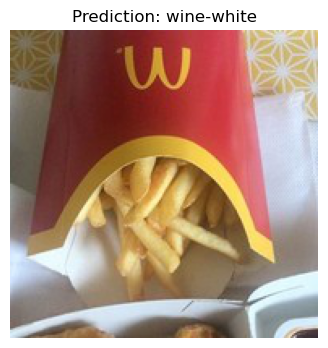

Predicted class: wine-white


In [126]:
show_image_and_prediction(cnn2, images_batch[13][:, :, :], label_encoder.classes_)

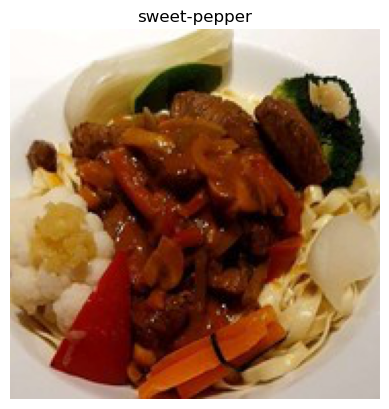

In [65]:
number = 20
plt.imshow(images_batch[0][:, :, :])
plt.axis('off')  # Turn off axis for a cleaner look
plt.show()

In [100]:
accuracy = cnn.calculate_accuracy(image_data[::20], y_train_one_hot[::20])
print(f"Test Accuracy: {accuracy:.2f}%")

KeyboardInterrupt: 